# Tests for Negative Binomial Noise Models (glm_nb)

This notebook shows the typical workflow of batchglm using simulated data.

In [1]:
import os
import datetime
import numpy as np
import pprint
import matplotlib.pyplot as plt
import logging
import warnings
import scipy
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
import batchglm.api as glm

np.warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow")
logging.getLogger("tensorflow").setLevel(logging.INFO)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

/home/mario/miniconda3/envs/batchglm_tf2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mario/miniconda3/envs/batchglm_tf2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mario/miniconda3/envs/batchglm_tf2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mario/miniconda3/envs/

## Setup

I/O parameters

In [3]:
out_dir = './' # specifies where figures should be stored

Some other parameter setups:

In [4]:
quick_scale = False # if True, only the mean model is trained which is much quicker
plot_figures = True # specifies whether figures should be plotted
save_figures = False # specifies whether figures should be saved
featurewise = True # if true, will only calculate updates on not yet converged parameters (feature batching).
autograd = False # if True, uses TensorFlow's integrated auto differentiation for jacobian and hessian calculation
                 # if False, uses implemented closed form differentiation, has no effect on closed form FIM calculation.

## Simulate some Data

First, we generate three different simulators with different number of observations and 500 features.

In [5]:
sim1 = glm.models.glm_nb.Simulator(10000,500)
sim2 = glm.models.glm_nb.Simulator(5000,500)
sim3 = glm.models.glm_nb.Simulator(1000,500)

Now data needs to be sampled from the simulated distributions.

In [6]:
sim1.generate()
sim2.generate()
sim3.generate()

Now we can visualize different batches and distributions for individual features by slicing the design matrix `x`.
Here, it is shown for `sim1.x`, where the individual batches and condition rows are extracted from the corresponding design matrix.

In [7]:
sim1.design_loc

array([[1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [1., 1., 0., 0., 1.]])

The first column denotes the intercept, followed by condition, then three columns for additional batches. The default is thereby made up of two conditions in a total of four batches. The simulator samples the same number of observation for each batch and alternates between condition 0 and 1 in each row in this example.
This might not be true if you change the above default simulators however. You need to have a look at the design matrix, then and slice it correctly, if you wish to plot the individual distributions per batch and conditions.

In [8]:
intercept_0 = sim1.x[:2500:2]
intercept_1 = sim1.x[1:2501:2]
batch_1_0 = sim1.x[2500:5000:2]
batch_1_1 = sim1.x[2501:5001:2]
batch_2_0 = sim1.x[5000:7500:2]
batch_2_1 = sim1.x[5001:7501:2]
batch_3_0 = sim1.x[7500:10000:2]
batch_3_1 = sim1.x[7501:10001:2]
#sim1.design_loc[500:1000:2]

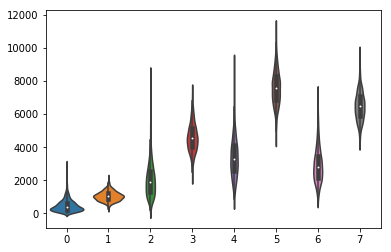

In [9]:
feature = 395
sns.violinplot(data=[intercept_0[:,feature],intercept_1[:,feature], batch_1_0[:,feature], batch_1_1[:,feature], batch_2_0[:,feature], batch_2_1[:,feature], batch_3_0[:,feature], batch_3_1[:,feature]])
plt.savefig('/home/mario/PSC19/batchglm_tf2/violins.pdf', bbox_inches="tight")


## Set up Estimator

Create the count matrix first. Here, you can choose to take a sparse csr_matrix or take `x` directly from the simulator. This will result in a sparse or dense tensor, respectively. Note that feature batching is currently not working with sparse x tensors, so you need to choose the dense x matrix directly from the simulator if you wish to try out feature batching. 

In [10]:
#x1 = sim1.x
x1 = scipy.sparse.csr_matrix(sim1.x)
#x2 = sim2.x
x2 = scipy.sparse.csr_matrix(sim2.x)
#x3 = sim3.x
x3 = scipy.sparse.csr_matrix(sim3.x)

Now create the design matrices. In this case, we take the design matrices for the loc and scale model which were created by the simulators.

In [11]:
design_loc_1 = sim1.design_loc
design_scale_1 = sim1.design_scale
design_loc_2 = sim2.design_loc
design_scale_2 = sim2.design_scale
design_loc_3 = sim3.design_loc
design_scale_3 = sim3.design_scale

Now create the input data for each individual run:

In [12]:
input_data1 = glm.models.glm_nb.InputDataGLM(data=x1, design_loc=design_loc_1, design_scale=design_scale_1)
input_data2 = glm.models.glm_nb.InputDataGLM(data=x2, design_loc=design_loc_2, design_scale=design_scale_2)
input_data3 = glm.models.glm_nb.InputDataGLM(data=x3, design_loc=design_loc_3, design_scale=design_scale_3)

Finally, the estimators are created:

In [13]:
estimator1 = glm.models.glm_nb.Estimator(input_data1, 
                init_a = "standard", init_b = "standard", quick_scale=quick_scale)
estimator2 = glm.models.glm_nb.Estimator(input_data2, 
                init_a = "standard", init_b = "standard", quick_scale=quick_scale)
estimator3 = glm.models.glm_nb.Estimator(input_data3, 
                init_a = "standard", init_b = "standard", quick_scale=quick_scale)

## Parameter Fitting Procedure

Choose optimizer (for glm_nb you should only use "adam" or "irls_gd_tr"): 

In [14]:
optim = "irls_gd_tr"

Start the training

In [15]:
estimator1.initialize()
estimator1.train(batched_model=False, batch_size=200, optimizer=optim, learning_rate=1e-2, 
                convergence_criteria="both", stopping_criteria=100, autograd=autograd, featurewise=featurewise, benchmark=True)

deviations1 = estimator1.model.trainable_weights[0].numpy()-np.concatenate((sim1.a,sim1.b),axis=0)
estimator2.initialize()
estimator2.train(batched_model=False, batch_size=200, optimizer=optim, learning_rate=1e-2, 
                convergence_criteria="both", stopping_criteria=100, autograd=autograd, featurewise=featurewise, benchmark=True)

deviations2 = estimator2.model.trainable_weights[0].numpy()-np.concatenate((sim2.a,sim2.b),axis=0)
estimator3.initialize()
estimator3.train(batched_model=False, batch_size=200, optimizer=optim, learning_rate=1e-2, 
                convergence_criteria="both", stopping_criteria=100, autograd=autograd, featurewise=featurewise, benchmark=True)

deviations3 = estimator3.model.trainable_weights[0].numpy()-np.concatenate((sim3.a,sim3.b),axis=0)


I1021 22:54:55.652695 139828282468160 estimator.py:157] step 0
W1021 22:54:55.659723 139825386604288 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W1021 22:54:55.660223 139825394996992 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W1021 22:54:55.660414 139825629861632 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W1021 22:54:55.660671 139825403389696 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W1021 22:54:55.660838 139825646647040 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
I1021 22:55:04.763368 139828282468160 estimator.py:244] Step: 5 loss: 214853.017438, converged 182, updated 500, (logs: 182, grad: 0, x_step: 0)
W1021 22:55:04.929954 139828282468160 deprecation.py:323] From /home/mario/miniconda3/envs/batchglm_tf2/lib/pyth

## Analysis

### Overall deviation

Check overall deviation between true and predicted values for mean and variance parameters

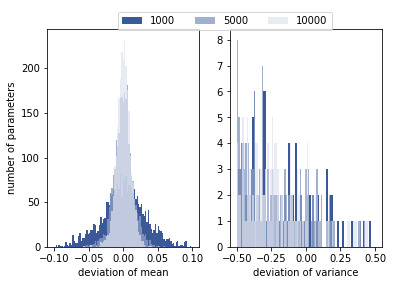

In [16]:
if plot_figures:
    fig, (ax1, ax2) = plt.subplots(1,2)
    a = ax1.hist(deviations3[0:5].flatten(),  bins = np.linspace(-0.1,0.1,100), color="#3b5998", alpha=1, histtype='stepfilled')
    b = ax1.hist(deviations2[0:5].flatten(),  bins = np.linspace(-0.1,0.1,100), color="#8b9dc3", alpha = 0.8, histtype='stepfilled')
    c = ax1.hist(deviations1[0:5].flatten(),  bins = np.linspace(-0.1,0.1,100), color="#dfe3ee", alpha=0.7, histtype='stepfilled')
    ax2.hist(deviations3[5:10].flatten(),  bins = np.linspace(-0.5,0.5,100), color="#3b5998", alpha=1, histtype='stepfilled')
    ax2.hist(deviations2[5:10].flatten(),  bins = np.linspace(-0.5,0.5,100), color="#8b9dc3", alpha=0.8, histtype='stepfilled')
    ax2.hist(deviations1[5:10].flatten(),  bins = np.linspace(-0.5,0.5,100), color="#dfe3ee", alpha=0.7, histtype='stepfilled')

    ax1.set_xlabel("deviation of mean")
    ax2.set_xlabel("deviation of variance")
    ax1.set_ylabel("number of parameters")
    plt.figlegend((a,b,c), labels=("1000","5000","10000"), loc = (0.30,0.895),ncol=3, labelspacing=0. )
    plt.plot()
    if save_figures:
        plt.tight_layout()
        plt.savefig("/home/mario/PSC19/batchglm_tf2/deviations.pdf", bbox_inches="tight")

All estimated parameters should be normally distributed around zero. The variance deviations only follow this distribution if they were fitted (check the `quick_scale` parameter).
With increasing number of observations, the variance should get smaller, which is caused by imperfection in the randomization process during sampling.

### Individual parameter convergence

Decide which batch/condition (coefficient) and feature to analyze:

In [17]:
coeff = 2
feature = 12

Decide which simulator and estimator to use:

In [18]:
estimator = estimator1
simulator = sim1

Assemble values

In [19]:
true_loc = simulator.a_var[coeff,feature]
true_scale = simulator.b_var[coeff,feature]
locs = [results[coeff,feature] for results in estimator.values]
scales = [results[coeff+5,feature] for results in estimator.values]

Plot the results from training for selected loc_param and feature:

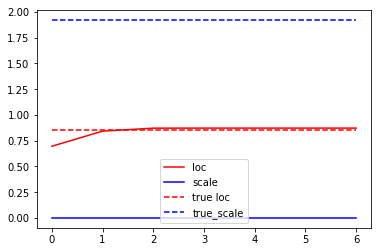

In [20]:
if plot_figures:
    num_steps = len(locs)
    #num_steps = 10
    loc_x = range(num_steps)
    scale_x = range(num_steps)
    plt.plot(loc_x, locs[0:num_steps], 'r',
             scale_x, scales[0:num_steps], 'b')
             #loc_x, locs_auto,'r--',
             #scale_x, scales_auto, 'b--')
    plt.plot(loc_x,[true_loc] * num_steps, 'r--',
             scale_x, [true_scale] * num_steps, 'b--')
    plt.legend(['loc', 'scale', 'true loc', 'true_scale'])
    plt.show()

### Final Parameter Comparison

Get absoute differences between each individual true and estimated parameter for selected estimator and simulator (see section above):

In [21]:
differences = np.abs(estimator.model.params.numpy()- np.concatenate((simulator.a, simulator.b), axis=0))

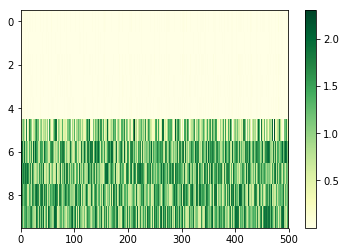

In [22]:
plt.imshow(differences, aspect='auto',cmap="YlGn")
plt.colorbar()

In [23]:
np.max(differences)

2.297892708103166

In [24]:
np.where(differences[0:5]==np.max(differences[0:5]))

(array([3]), array([117]))